# INFO

Requirements:
- Data files: all the data folders/files are available in the repository (see below)
    All the folders are already available in repository 
- Python 3.9 or newer
- modules: pandas, numpy, matplotlib, scipy


Data content:

- SEVN_simulations: 
    - run_sse_ov04.sh, SEVN run script to run SSE using tables with ov=0.4
    - run_sse_ov05.sh, SEVN run script to run SSE using tables with ov=0.5
    - SEVN_ilist.dat, initial conditions for SEVN
    - sevn_output_ov04, SEVN SSE output (tables with ov=0.4)
    - sevn_output_ov05, SEVN SSE output (tables with ov=0.5)
- evolv_mosse
    - Folder containing the outpur of MOSSE (MOBSE SSE) 
    
    


In [1]:
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

import matplotlib as mpl
label_size =18
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size
#mpl.rcParams['mathtext.default']='regular'
mpl.rcParams.update({'figure.autolayout': True})
mpl.rcParams['contour.negative_linestyle'] = 'solid'
mpl.rcParams['axes.facecolor'] = 'white'
import warnings
warnings.filterwarnings('ignore')
import subprocess

import matplotlib.colors as colors

def load_mobse(M,Z):
    df = pd.read_csv(f"evolv_mosse/evolve_{Z}_{M}.dat",sep="\s+",skiprows=1,header=None,
                    names=["Worldtime","Phase","Mo","Mass","Luminosity","Radius","Temperature","MHE","Menv","Epoch","Spin"])
    
    df["Luminosity"] = 10**df["Luminosity"]
    df["Radius"] = 10**df["Radius"]
    df["Temperature"] = 10**df["Temperature"]
    idx = df.Phase<10
    
    
    return df[idx]


def load_sevn(M,Z,ov):
    
    df=pd.read_csv(f"SEVN_simulations/sevn_output_ov{ov}/output_0.csv")
    idx=(df.Zams==M)&(df.Zmet==Z)
    ID=df[idx&(df.Worldtime==0)].ID.values[0]
    idx = (df.Phase<7)&(df.ID==ID)
    
    return df[idx]


def plot_radii(R,ax,htext=5.65,Rlabel=None):
    
    T0=5778
    
    L = lambda T,R: np.log10(R*R*(T/T0)**4)
    Tr = lambda ll,R: np.log10(T0*((ll/R**2)**(1/4)))*1.001
    
    ylim=ax.get_ylim()
    xlim=ax.get_xlim()

    if Rlabel is None: Rlabel=R

    T=np.logspace(np.log10(1e2),np.log10(1e7))
    for rr in R:
        LL=L(T,rr)
        ax.plot(np.log10(T),LL,c="gray",zorder=-10,ls="dotted")
        htext=htext+0.01
        
        #idx_inside=(LL>ylim[0])&(LL<ylim[1])&(np.log10(T)>xlim[0])&(np.log10(T)<xlim[1])

        if rr in Rlabel:
            ax.text(Tr(10**htext,rr),htext,f"{rr} \nR$_\odot$",fontsize=label_size-4,color="gray")




def find_important_points(df):
    
    
    Tv=df.Temperature.values
    Lv=df.Luminosity.values
    
    #Starts 
    ip={"start":(Tv[0],Lv[0],"o")}
    #Hecore
    idx=df.MHE>0
    ip["He"]=(Tv[idx][0],Lv[idx][0],"^")
    #HecoreBurning
    idx=df.Phase==4
    ip["CHeB"]=(Tv[idx][0],Lv[idx][0],"X")
    
    
    #NakedHe
    if "PhaseBSE"  not in df.columns: idx=df.Phase>=7
    else: idx=df.Mass==df.MHE
        
    if(np.sum(idx)==0): ip["WR"]=(np.nan,np.nan,"d")
    else: ip["WR"]=(Tv[idx][0],Lv[idx][0],"d")

    
    return ip
    

def plot_track(df,ax,opt_dict):
    
    ips=find_important_points(df)
    for ip in ips:
        ax.scatter(np.log10(ips[ip][0]),np.log10(ips[ip][1]),marker=ips[ip][2],zorder=1000,c=opt_dict["c"],
                  ec="k",s=200)
    
    #ax.scatter(np.log10(df.Temperature),np.log10(df.Luminosity),c=df.MHE,vmin=0,vmax=)
    ax.plot(np.log10(df.Temperature),np.log10(df.Luminosity),**opt_dict)
   


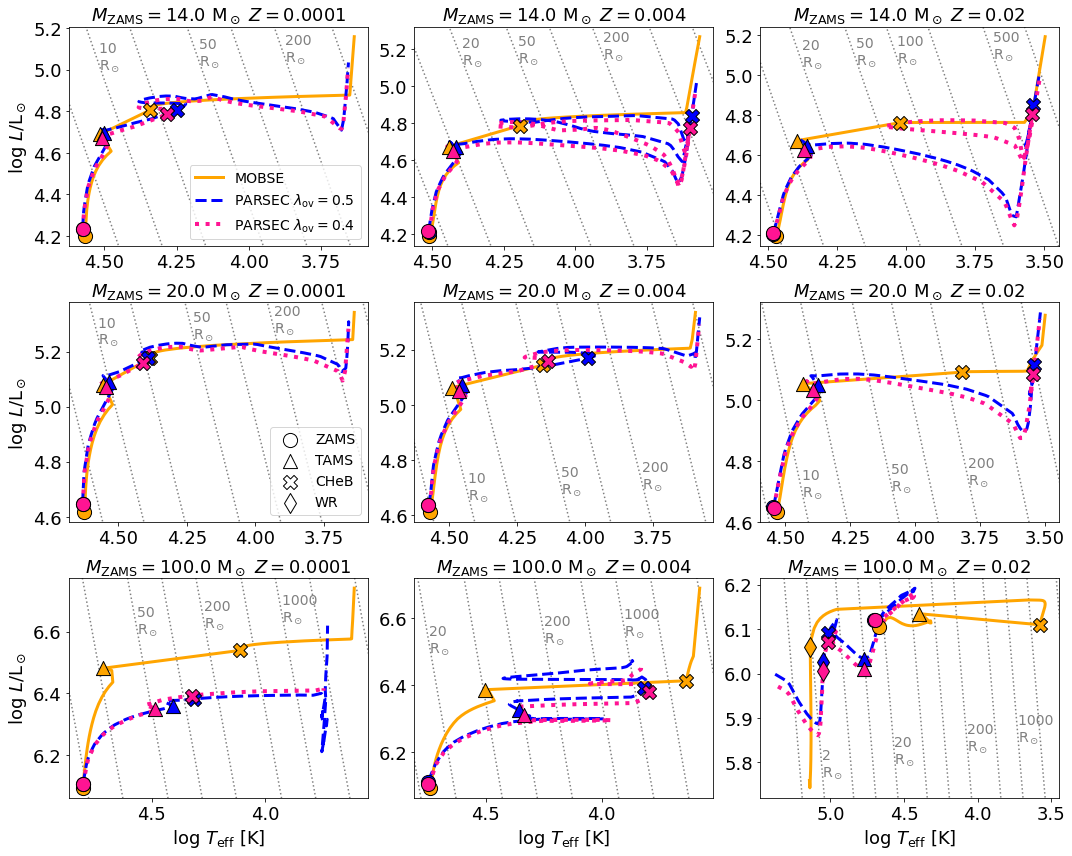

In [15]:
Mlist=(14.0,20.0,100.0)
Zlist=(0.0001,0.004,0.02)

fig, axl = plt.subplots(3,3,figsize=(15,12))

Mopt={"ls":"solid", "lw":3, "c":"orange"}
S5opt={"ls":"dashed", "lw":3, "c":"blue"}
S4opt={"ls":"dotted", "lw":4, "c":"deeppink"}



Rlist=np.array([np.array([1,2,5])*n for n in (1,10,100,1000)]).flatten()

for i,(M,axx) in enumerate(zip(Mlist,axl)):
    for j,(Z,ax) in enumerate(zip(Zlist,axx)):
        dfM=load_mobse(M,Z)
        dfS5=load_sevn(M,Z,"05")
        dfS4=load_sevn(M,Z,"04")
        plot_track(dfM,ax,Mopt)
        plot_track(dfS5,ax,S5opt)
        plot_track(dfS4,ax,S4opt)
        
        xlim=ax.get_xlim()
        ylim=ax.get_ylim()
        
        if i==0 and j==2: plot_radii(Rlist,ax,htext=0.953*ylim[1],Rlabel=(20,50,100,500))
        elif i==0 and j==1: plot_radii(Rlist,ax,htext=0.953*ylim[1],Rlabel=(20,50,200))
        elif i==0 and j==0: 
            plot_radii(Rlist,ax,htext=0.953*ylim[1],Rlabel=(10,50,200))
            ax.plot([0,1],[0,1],**Mopt,label="MOBSE")
            ax.plot([0,1],[0,1],**S5opt,label="PARSEC $\lambda_\mathrm{ov}=0.5$")
            ax.plot([0,1],[0,1],**S4opt,label="PARSEC $\lambda_\mathrm{ov}=0.4$")
            ax.legend(loc="lower right",fontsize=label_size-4)
        elif i==1 and j==2: plot_radii(Rlist,ax,htext=1.01*ylim[0],Rlabel=(10,50,200))
        elif i==1 and j==1: plot_radii(Rlist,ax,htext=1.01*ylim[0],Rlabel=(10,50,200))  
        elif i==1 and j==0: 
            plot_radii(Rlist,ax,htext=0.965*ylim[1],Rlabel=(10,50,200))  
            ax.scatter([0,],[0,],s=200, marker="o",ec="k",c="white",label="ZAMS")
            ax.scatter([0,],[0,],s=200, marker="^",ec="k",c="white",label="TAMS")
            ax.scatter([0,],[0,],s=200, marker="X",ec="k",c="white",label="CHeB")
            ax.scatter([0,],[0,],s=200, marker="d",ec="k",c="white",label="WR")
            ax.legend(loc="lower right",fontsize=label_size-4)
        elif i==2 and j==2: plot_radii(Rlist,ax,htext=1.005*ylim[0],Rlabel=(2,20,200,1000)) 
        elif i==2 and j==1: plot_radii(Rlist,ax,htext=0.96*ylim[1],Rlabel=(20,200,1000)) 
        elif i==2 and j==0: plot_radii(Rlist,ax,htext=0.965*ylim[1],Rlabel=(50,200,1000)) 
        

        #plot_radii((1,2,5,10,20,50,100,200,500,1000,2000,5000),ax,htext=0.99*ylim[1])
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        
        ax.invert_xaxis()    
        if j==0: ax.set_ylabel("log $L$/L$_\odot$",fontsize=label_size)
        if i==2: ax.set_xlabel("log $T_\mathrm{eff}$ [K]",fontsize=label_size)
        
        #if i==0:
        ax.set_title(f"$M_\mathrm{{ZAMS}}={M} \ \mathrm{{M}}_\odot$ $Z={Z}$",fontsize=label_size)


plt.tight_layout()
plt.savefig("TrackCompare.pdf")

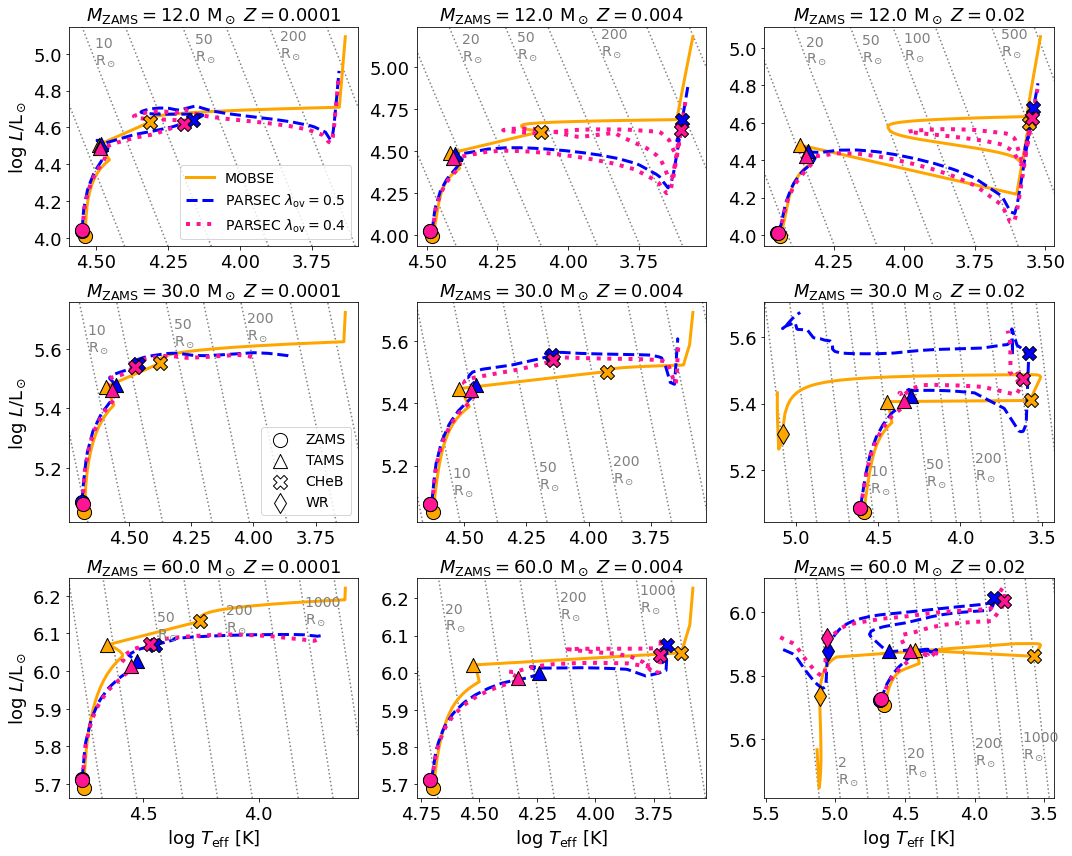

In [16]:
Mlist=(12.0,30.0,60.0)
Zlist=(0.0001,0.004,0.02)

fig, axl = plt.subplots(3,3,figsize=(15,12))

Mopt={"ls":"solid", "lw":3, "c":"orange"}
S5opt={"ls":"dashed", "lw":3, "c":"blue"}
S4opt={"ls":"dotted", "lw":4, "c":"deeppink"}



Rlist=np.array([np.array([1,2,5])*n for n in (1,10,100,1000)]).flatten()

for i,(M,axx) in enumerate(zip(Mlist,axl)):
    for j,(Z,ax) in enumerate(zip(Zlist,axx)):
        dfM=load_mobse(M,Z)
        dfS5=load_sevn(M,Z,"05")
        dfS4=load_sevn(M,Z,"04")
        plot_track(dfM,ax,Mopt)
        plot_track(dfS5,ax,S5opt)
        plot_track(dfS4,ax,S4opt)
        
        xlim=ax.get_xlim()
        ylim=ax.get_ylim()
        
        if i==0 and j==2: plot_radii(Rlist,ax,htext=0.953*ylim[1],Rlabel=(20,50,100,500))
        elif i==0 and j==1: plot_radii(Rlist,ax,htext=0.953*ylim[1],Rlabel=(20,50,200))
        elif i==0 and j==0: 
            plot_radii(Rlist,ax,htext=0.953*ylim[1],Rlabel=(10,50,200))
            ax.plot([0,1],[0,1],**Mopt,label="MOBSE")
            ax.plot([0,1],[0,1],**S5opt,label="PARSEC $\lambda_\mathrm{ov}=0.5$")
            ax.plot([0,1],[0,1],**S4opt,label="PARSEC $\lambda_\mathrm{ov}=0.4$")
            ax.legend(loc="lower right",fontsize=label_size-4)
        elif i==1 and j==2: plot_radii(Rlist,ax,htext=1.01*ylim[0],Rlabel=(10,50,200))
        elif i==1 and j==1: plot_radii(Rlist,ax,htext=1.01*ylim[0],Rlabel=(10,50,200))  
        elif i==1 and j==0: 
            plot_radii(Rlist,ax,htext=0.965*ylim[1],Rlabel=(10,50,200))  
            ax.scatter([0,],[0,],s=200, marker="o",ec="k",c="white",label="ZAMS")
            ax.scatter([0,],[0,],s=200, marker="^",ec="k",c="white",label="TAMS")
            ax.scatter([0,],[0,],s=200, marker="X",ec="k",c="white",label="CHeB")
            ax.scatter([0,],[0,],s=200, marker="d",ec="k",c="white",label="WR")
            ax.legend(loc="lower right",fontsize=label_size-4)
        elif i==2 and j==2: plot_radii(Rlist,ax,htext=1.005*ylim[0],Rlabel=(2,20,200,1000)) 
        elif i==2 and j==1: plot_radii(Rlist,ax,htext=0.97*ylim[1],Rlabel=(20,200,1000)) 
        elif i==2 and j==0: plot_radii(Rlist,ax,htext=0.965*ylim[1],Rlabel=(50,200,1000)) 
        

        #plot_radii((1,2,5,10,20,50,100,200,500,1000,2000,5000),ax,htext=0.99*ylim[1])
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        
        ax.invert_xaxis()    
        if j==0: ax.set_ylabel("log $L$/L$_\odot$",fontsize=label_size)
        if i==2: ax.set_xlabel("log $T_\mathrm{eff}$ [K]",fontsize=label_size)
        
        #if i==0:
        ax.set_title(f"$M_\mathrm{{ZAMS}}={M} \ \mathrm{{M}}_\odot$ $Z={Z}$",fontsize=label_size)


plt.tight_layout()
plt.savefig("TrackCompare_123060.pdf")